In [1]:
from itertools import permutations
from random import shuffle

import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
learning_rate = 0.001
num_steps = 100
batch_size = 16
display_step = 1000
n_epochs = 2

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 2 
num_classes = 1

#Equation Parameters
D = 1
C0 = 0.1


# tf Graph input
X = tf.placeholder("float", [None, 1])
T = tf.placeholder("float", [None, 1])

In [3]:
x = np.linspace(start=0,stop=10,num=1000).reshape(-1,1)
t = np.linspace(start=0,stop=100,num=1000).reshape(-1,1)

In [4]:
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    #'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


In [5]:
# Create model
def neural_net(x,t):
    netin = tf.concat([x,t],1)
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(netin, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

In [6]:
tf.shape(X)[0]

<tf.Tensor 'strided_slice:0' shape=() dtype=int32>

In [7]:
zero = X*0.0
net = neural_net(X, T)
net_dt = tf.concat(tf.gradients(xs = [T],ys = net), 1)
net_dx1 = tf.concat(tf.gradients(xs = [X], ys = net), 1)
net_dx2 = tf.concat(tf.gradients(xs = [X], ys = net_dx1), 1)

In [8]:
loss_op = tf.square(D*net_dx2-net_dt)+tf.square(neural_net(zero,T)-C0)+tf.square(neural_net(X,zero))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [13]:
class BatchGenerator:
    def __init__(self, n_samples, batch_size):
        self.n_samples = n_samples
        self.idx = list(range(n_samples))
        shuffle(self.idx)
        self.current = 0
        self.batch_size = batch_size
        self.iter = permutations(self.idx,2)
    
    def __len__(self):
        return int(len(self.iter)/self.batch_size)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        idx,idt = [],[]
        for i in range(self.batch_size):
            x, t = next(self.iter)
            idx.append(x)
            idt.append(t)
        return idx,idt

In [14]:
init = tf.global_variables_initializer()
losses = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        batch_generator = BatchGenerator(n_samples=x.shape[0],batch_size=batch_size)
        for batch_idx,batch_idt in tqdm(batch_generator):
            #batch_idx = np.random.randint(low=0,high = x.shape[0],size = batch_size)
            #batch_idt = np.random.randint(low=0,high = x.shape[0],size = batch_size)
            batch_x = x[batch_idx]
            batch_t = t[batch_idt]
            sess.run(train_op, feed_dict={X: batch_x, T: batch_t})
        # Calculate batch loss and accuracy
        loss = sess.run(loss_op, feed_dict={X: batch_x,T: batch_t})
        #print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss))
        losses.append(loss)
        #print(loss)
    saver.save(sess, './solution.ckpt')

62437it [01:36, 646.84it/s]
62437it [01:50, 562.72it/s]


In [15]:
losses

[array([[1.7018351e-06],
        [2.8048919e-07],
        [2.7779870e-06],
        [1.0950333e-06],
        [1.5995081e-06],
        [1.1524130e-06],
        [2.5739278e-06],
        [3.7319379e-07],
        [1.5101404e-06],
        [2.1572009e-06],
        [4.6465891e-07],
        [6.0313312e-07],
        [4.7842127e-07],
        [2.6857697e-06],
        [1.0241814e-06],
        [7.4880711e-07]], dtype=float32), array([[4.4789281e-06],
        [1.8659332e-04],
        [4.7868230e-06],
        [6.6444568e-06],
        [6.6155944e-06],
        [6.8007485e-06],
        [5.7964799e-06],
        [5.0326857e-06],
        [4.7010849e-06],
        [5.8965634e-06],
        [6.6094622e-06],
        [5.3599083e-06],
        [4.4246058e-06],
        [1.3194348e-05],
        [5.4300012e-06],
        [6.6562116e-06]], dtype=float32)]

In [32]:
init = tf.global_variables_initializer()
#tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,'./solution.ckpt')
    x_in = x.reshape(-1,1)
    t_in = 50.0*np.ones(x.shape[0]).reshape(-1,1)
    profile = sess.run(net, feed_dict={X:x_in,T:t_in})

INFO:tensorflow:Restoring parameters from ./solution.ckpt


In [34]:
def compute_profile(time, model_path='./solution.ckpt'):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess,'./solution.ckpt')
        x_in = x.reshape(-1,1)
        t_in = time*np.ones(x.shape[0]).reshape(-1,1)
        profile = sess.run(net, feed_dict={X:x_in,T:t_in})
    return profile

In [35]:
profile = compute_profile(0)

INFO:tensorflow:Restoring parameters from ./solution.ckpt


In [36]:
np.mean(profile)

8.027246e-05

INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt


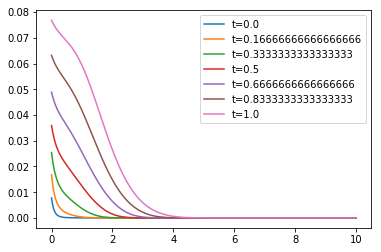

In [51]:
times = np.linspace(0,1,7).tolist()
legend = []
for time in times:
    profile = compute_profile(time)
    plt.plot(x,profile)
    legend.append(f"t={time}")
plt.legend(legend)
plt.show()

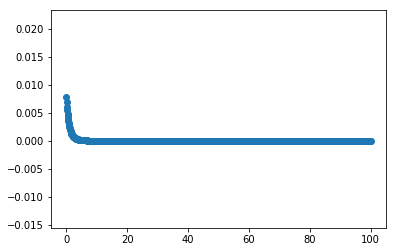

In [37]:
plt.scatter(x=t,y = profile)